<a href="https://colab.research.google.com/github/smcdonou02/McDonut/blob/main/TournamentDES_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:

import simpy
import numpy as np
import pandas as pd

In [2]:
CONFIG_FILE = "/content/drive/MyDrive/2024-2025 /_SSY611_Team_Project/Python Simulation Script/Simulation Script/ADCC_2025_US_Open - Orlando_FL_Config_From_Raw.xlsx"

SCENARIOS = {
    "A": {"no_show_dq": 0.07, "submission": 0.38, "points": 0.55},
    "B": {"no_show_dq": 0.05, "submission": 0.55, "points": 0.40},
    "C": {"no_show_dq": 0.15, "submission": 0.35, "points": 0.50},
    "D": {"no_show_dq": 0.05, "submission": 0.25, "points": 0.70},
}

SELECTED_SCENARIO = "D"

NUM_MATS = 8
CHECKIN_STAFF = 10

ARRIVAL_START = -30.0
ARRIVAL_END = 10.0
BRACKET_START = 30.0

CHECKIN_MIN = 0.5
CHECKIN_MAX = 1.5

BUFFER_MIN = 1.0
BUFFER_MAX = 3.0

RANDOM_SEED = 42

In [3]:
#import data file, clean up any bad data
def load_tournament_divisions(path):
  df = pd.read_excel(path)
  df["Num_Competitors"] = pd.to_numeric(df["Num_Competitors"], errors="coerce").fillna(0).astype(int)
  df["Match_Time_Min"] = pd.to_numeric(df["Match_Time_Min"], errors="coerce").fillna(5.0).astype(float)
  return df

def compute_rounds(n):
    rounds = []
    c = n
    while c > 1:
        m = c // 2
        b = c % 2
        rounds.append((m, b))
        c = m + b
    return rounds


In [4]:
class DivisionDES:
    def __init__(self, env, row, checkin_res, mat_res, scen, rng):
        self.env = env
        self.row = row
        self.div_name = row["Division_Code"]
        self.n = int(row["Num_Competitors"])
        self.match_time = float(row["Match_Time_Min"])
        self.start_time = 0.0
        self.rounds = compute_rounds(self.n)

        self.checkin_res = checkin_res
        self.mat_res = mat_res
        self.scen = scen
        self.rng = rng

        self.ready_store = simpy.Store(env)

        self.results = []
        self.div_finish = None

    # ---------------------
    # Competitor process
    # ---------------------
    def competitor(self, cid):
        # arrival uniform between ARRIVAL_START and ARRIVAL_END
        offset = self.rng.uniform(ARRIVAL_START, ARRIVAL_END)
        t_arr = BRACKET_START + offset

        yield self.env.timeout(max(0, t_arr - self.env.now))

        # check-in
        with self.checkin_res.request() as req:
            yield req
            svc = self.rng.uniform(CHECKIN_MIN, CHECKIN_MAX)
            yield self.env.timeout(svc)

        yield self.ready_store.put(cid)


    # ---------------------
    # Match process
    # ---------------------
    def match(self, round_num, cidA, cidB):
      # --- get a specific mat ID ---
      mat_id = yield self.mat_res.get()
      start = self.env.now

      # Scenario outcome
      outcome = self.rng.choice(
        ["dq", "sub", "pts"],
        p=[self.scen["no_show_dq"],
           self.scen["submission"],
           self.scen["points"]]
      )

      if outcome == "dq":
        duration = 0.1
      elif outcome == "sub":
        duration = self.rng.uniform(0.5, self.match_time - 0.1)
      else:
        duration = self.match_time

      # Run match time
      yield self.env.timeout(duration)

      turnover = self.rng.uniform(BUFFER_MIN, BUFFER_MAX)
      yield self.env.timeout(turnover)

      end = self.env.now

      yield self.mat_res.put(mat_id)

      # Pick winner
      winner = cidA if self.rng.random() < 0.5 else cidB

      self.results.append(dict(
            Division=self.div_name,
            Round=round_num,
            Match=(cidA, cidB),
            Winner=winner,
            Start=start,
            End=end,
            Duration=duration,
            Turnover=turnover,
            Mat=mat_id,
            Outcome=outcome,
        ))
      return winner

    # ---------------------
    # Division driver
    # ---------------------
    def run(self):
        # start competitor arrivals/check-in
        for cid in range(1, self.n+1):
            self.env.process(self.competitor(cid))

        # Wait until bracket start
        yield self.env.timeout(BRACKET_START)

        # Start bracket progression
        competitors = []
        while len(competitors) < self.n:
            cid = yield self.ready_store.get()
            competitors.append(cid)

        # Now run rounds
        current_competitors = competitors

        for r, (num_matches, byes) in enumerate(self.rounds, start=1):
            winners = []
            procs = []
            idx = 0

            # Match processes for this round
            for _ in range(num_matches):
                A = current_competitors[idx]
                B = current_competitors[idx + 1]
                idx += 2
                p = self.env.process(self.match(r, A, B))
                procs.append(p)

            # Bye (odd competitor advances automatically)
            if byes == 1:
                winners.append(current_competitors[-1])

            # Wait for all matches in the round to finish
            finished = yield simpy.events.AllOf(self.env, procs)
            for ev in finished.events:
                winners.append(ev.value)

            current_competitors = winners  # survivors to next round

        # Division finish time: last match end
        self.div_finish = self.env.now

In [5]:
def run_tournament(df, scenario="A", num_mats=4, staff=10, seed=42):
    rng = np.random.default_rng(seed)
    env = simpy.Environment()

    checkin_res = simpy.Resource(env, capacity=staff)
    mat_res = simpy.FilterStore(env, capacity=num_mats)
    mat_res.items = list(range(num_mats))  # mat IDs 0..num_mats-1

    scen = SCENARIOS[scenario]

    divisions = []
    for _, row in df.iterrows():
        if row["Num_Competitors"] < 2:
            continue
        d = DivisionDES(env, row, checkin_res, mat_res, scen, rng)
        divisions.append(d)
        env.process(d.run())

    env.run()

    # -------------------------------
    # Collect results
    # -------------------------------
    all_matches = []
    summary = []

    for d in divisions:
        all_matches.extend(d.results)
        summary.append({
            "Division": d.div_name,
            "Competitors": d.n,
            "Finish": d.div_finish
        })

    matches_df = pd.DataFrame(all_matches)
    summary_df = pd.DataFrame(summary)

    return {
        "matches": matches_df,
        "summary": summary_df,
        "tournament_finish": summary_df["Finish"].max(),
    }

In [6]:
df = load_tournament_divisions(CONFIG_FILE)
result = run_tournament(df, scenario=SELECTED_SCENARIO, num_mats=NUM_MATS, staff=CHECKIN_STAFF)
matches = result["matches"]
summary = result["summary"]
T = result["tournament_finish"]

print(matches)
print(summary)
hours = T / 60
print(T)
print(f"Tournament duration: {hours:.2f} hours")


                   Division  Round   Match  Winner       Start         End  \
0        Intermediate_550kg      1  (4, 1)       1  173.470137  179.258032   
1        Intermediate_550kg      1  (5, 2)       5  173.034158  179.575098   
2        Intermediate_550kg      2  (3, 5)       5  517.523399  520.158980   
3        Intermediate_550kg      3  (1, 5)       5  680.479584  687.093986   
4            Advanced_280kg      1  (4, 2)       4  391.089758  393.293292   
..                      ...    ...     ...     ...         ...         ...   
978  Adult15_Beginner_760kg      1  (5, 6)       6  213.447450  220.033322   
979  Adult15_Beginner_760kg      1  (3, 1)       3  213.897096  221.675699   
980  Adult15_Beginner_760kg      2  (8, 2)       2  537.305451  542.924408   
981  Adult15_Beginner_760kg      2  (6, 3)       3  537.461614  543.775636   
982  Adult15_Beginner_760kg      3  (2, 3)       2  692.803774  700.329754   

     Duration  Turnover  Mat Outcome  
0    3.488240  2.299655 

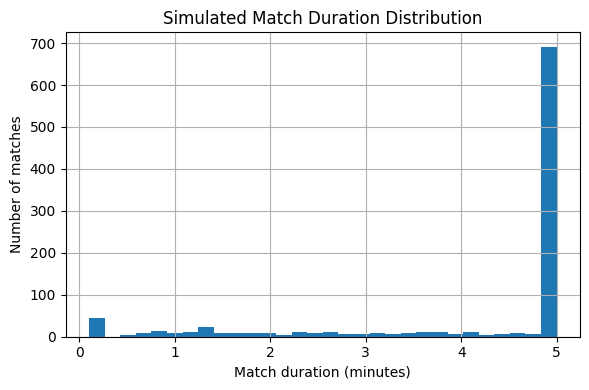

In [7]:
import matplotlib.pyplot as plt

def plot_match_duration_hist(matches):
    plt.figure(figsize=(6,4))
    matches["Duration"].hist(bins=30)
    plt.xlabel("Match duration (minutes)")
    plt.ylabel("Number of matches")
    plt.title("Simulated Match Duration Distribution")
    plt.tight_layout()
    plt.show()

plot_match_duration_hist(matches)

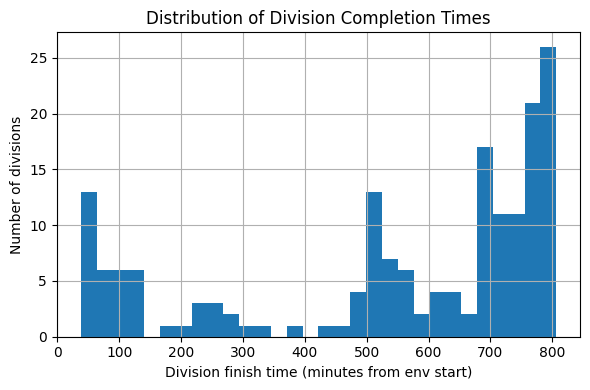

In [9]:
def plot_division_finish_hist(summary):
    plt.figure(figsize=(6,4))
    summary["Finish"].hist(bins=30)
    plt.xlabel("Division finish time (minutes from env start)")
    plt.ylabel("Number of divisions")
    plt.title("Distribution of Division Completion Times")
    plt.tight_layout()
    plt.show()

plot_division_finish_hist(summary)

In [20]:
def monte_carlo(df, N=100, mats_list=[4,5,6], staff_list=[5,10,15], scenario="B"):
    results = []

    for mats in mats_list:
        for staff in staff_list:
            durations = []

            for i in range(N):
                out = run_tournament(df, scenario=scenario, num_mats=mats, staff=staff, seed=1000+i)
                dur = out["tournament_finish"]
                durations.append(dur)

            results.append(dict(
                mats=mats,
                staff=staff,
                durations=durations,           # <--- key addition!
                avg_duration=np.mean(durations),
                p95_duration=np.percentile(durations,95),
            ))

    return results   # now returns a list of dicts, not a DataFrame


In [21]:
df = load_tournament_divisions(CONFIG_FILE)

# Run Monte Carlo across mats + staff
mc = monte_carlo(df, N=100, mats_list=[8, 10, 14], staff_list=[5,10,15])
print(mc)

[{'mats': 8, 'staff': 5, 'durations': [792.4728190590157, 797.1219369545545, 807.2977611173242, 797.6049828592544, 804.13497724175, 796.2609276863857, 811.530539792866, 813.3152069622892, 800.2221698734661, 798.8338987650562, 795.6495388845601, 797.3787556433006, 800.1518987515232, 781.4961623089932, 806.9506254532461, 793.1954973166563, 795.3544845361384, 792.8646952974527, 798.3624700328115, 800.8563134100289, 788.6106052748399, 801.4155479653932, 808.7177903069886, 793.3438217793553, 796.4742771455307, 795.6418883641437, 816.2837252155008, 783.7360057021131, 807.1670565703383, 798.0683409260776, 785.2220853555503, 792.6465856195455, 799.4027773040756, 810.4965901630991, 793.4696287558064, 783.9948381249676, 799.0188204759256, 793.1960286817039, 803.3355437380702, 803.1875035408665, 793.1148760735024, 801.6106447319723, 795.7245176084315, 795.1469374700937, 790.5947136551202, 794.5582324083791, 789.3620258180331, 771.2250676242575, 800.7725508575533, 786.4650311511116, 811.4764269967

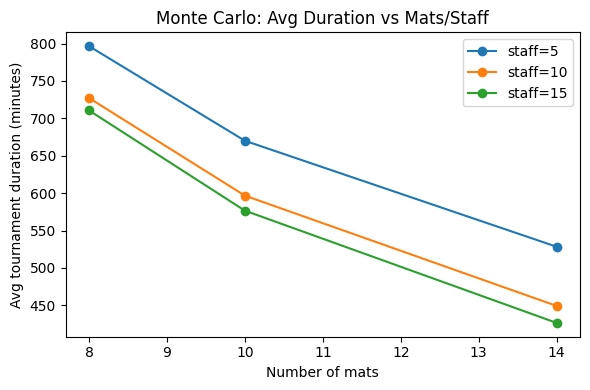

In [24]:
def plot_mc_summary(mc):
    # Convert list of dicts → DataFrame
    mc_df = pd.DataFrame(mc)

    plt.figure(figsize=(6,4))

    for staff in sorted(mc_df["staff"].unique()):
        subset = mc_df[mc_df["staff"] == staff]
        plt.plot(subset["mats"], subset["avg_duration"], marker="o", label=f"staff={staff}")

    plt.xlabel("Number of mats")
    plt.ylabel("Avg tournament duration (minutes)")
    plt.title("Monte Carlo: Avg Duration vs Mats/Staff")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_mc_summary(mc)

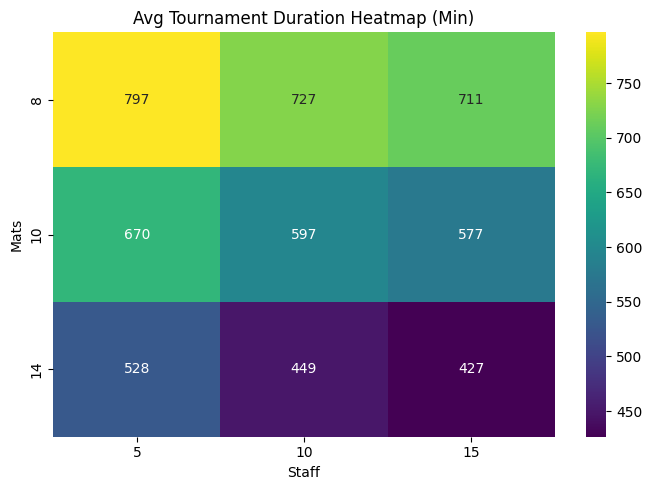

In [35]:
def plot_duration_heatmap(mc):
    df = pd.DataFrame(mc)
    pivot = df.pivot(index="mats", columns="staff", values="avg_duration")

    plt.figure(figsize=(7,5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="viridis")
    plt.title("Avg Tournament Duration Heatmap (Min)")
    plt.ylabel("Mats")
    plt.xlabel("Staff")
    plt.tight_layout()
    plt.show()

plot_duration_heatmap(mc)

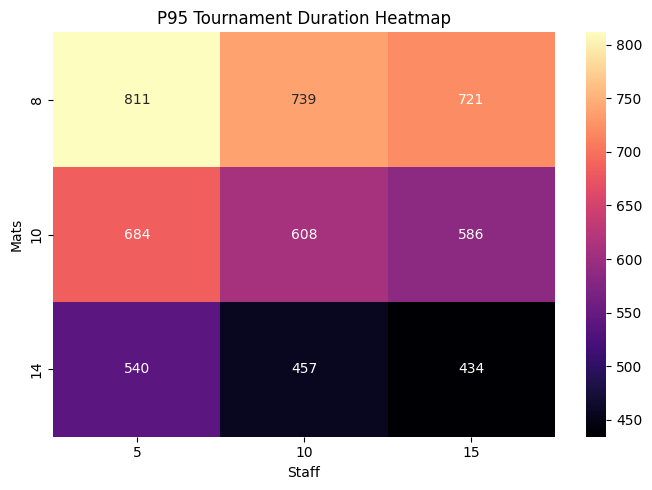

In [36]:
def plot_p95_heatmap(mc):
    df = pd.DataFrame(mc)
    pivot = df.pivot(index="mats", columns="staff", values="p95_duration")

    plt.figure(figsize=(7,5))
    sns.heatmap(pivot, annot=True, fmt=".0f", cmap="magma")
    plt.title("P95 Tournament Duration Heatmap")
    plt.ylabel("Mats")
    plt.xlabel("Staff")
    plt.tight_layout()
    plt.show()

plot_p95_heatmap(mc)


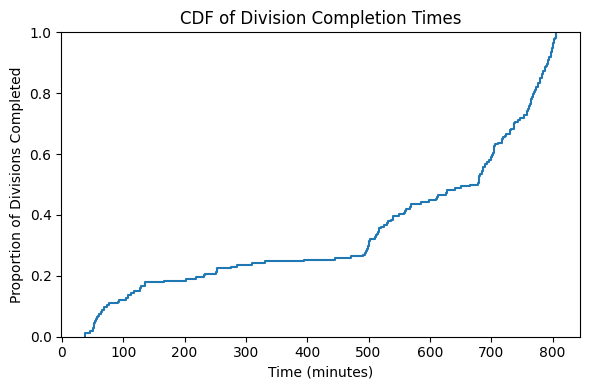

In [37]:
def plot_division_cdf(summary):
    plt.figure(figsize=(6,4))
    sns.ecdfplot(summary["Finish"])
    plt.title("CDF of Division Completion Times")
    plt.xlabel("Time (minutes)")
    plt.ylabel("Proportion of Divisions Completed")
    plt.tight_layout()
    plt.show()

plot_division_cdf(summary)

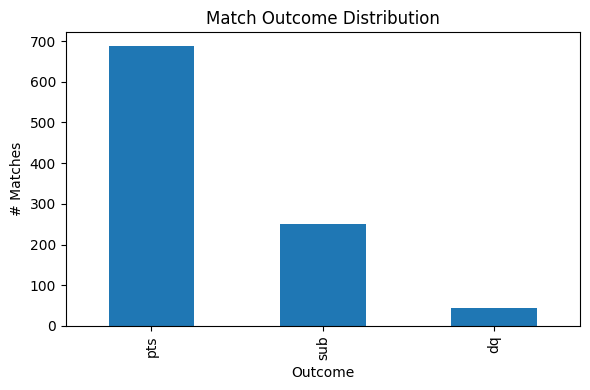

In [38]:
def plot_outcome_distribution(matches):
    plt.figure(figsize=(6,4))
    matches["Outcome"].value_counts().plot(kind="bar")
    plt.title("Match Outcome Distribution")
    plt.xlabel("Outcome")
    plt.ylabel("# Matches")
    plt.tight_layout()
    plt.show()

plot_outcome_distribution(matches)

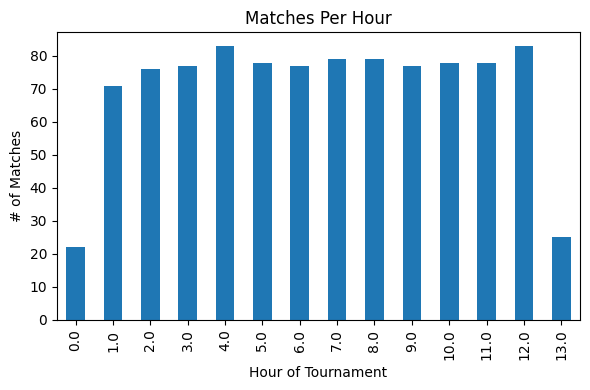

In [41]:
def plot_throughput(matches):
    matches["hour"] = matches["Start"] // 60
    throughput = matches.groupby("hour")["Match"].count()

    plt.figure(figsize=(6,4))
    throughput.plot(kind="bar")
    plt.title("Matches Per Hour")
    plt.xlabel("Hour of Tournament")
    plt.ylabel("# of Matches")
    plt.tight_layout()
    plt.show()

plot_throughput(matches)

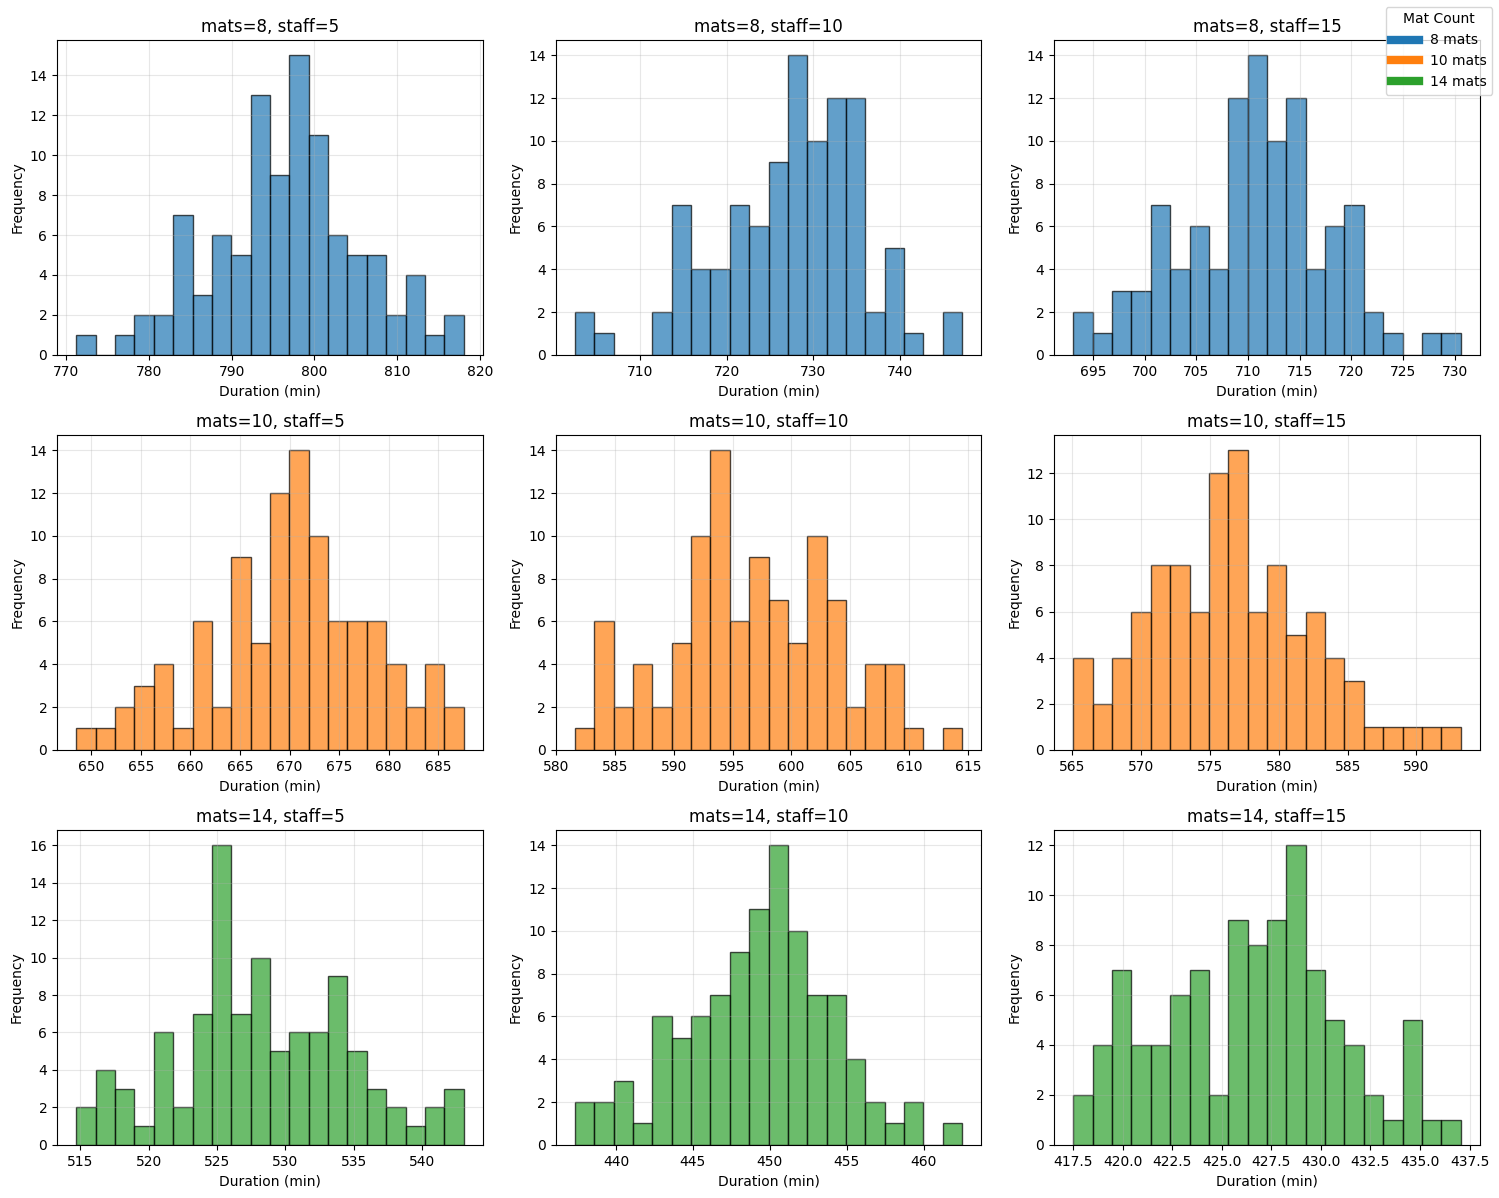

In [34]:
import seaborn as sns
import pandas as pd
import math

def plot_mc_hist_grid(results):

    df = pd.DataFrame(results)
    configs = df[["mats","staff"]].values.tolist()

    unique_mats = sorted(df["mats"].unique())
    palette = sns.color_palette("tab10", n_colors=len(unique_mats))
    # Map each mat count to a color
    mat_to_color = {m: palette[i] for i, m in enumerate(unique_mats)}


    num_plots = len(configs)
    cols = 3
    rows = math.ceil(num_plots / cols)

    fig, axes = plt.subplots(rows, cols, figsize=(15, 4 * rows))
    axes = axes.flatten()

    for ax, (mats, staff) in zip(axes, configs):
        # find data
        durations = None
        for r in results:
            if r["mats"] == mats and r["staff"] == staff:
                durations = r["durations"]

        ax.hist(durations, bins=20, alpha=0.7, edgecolor="black", color=mat_to_color[mats])
        ax.set_title(f"mats={mats}, staff={staff}")
        ax.set_xlabel("Duration (min)")
        ax.set_ylabel("Frequency")
        ax.grid(True, alpha=0.3)

    # Hide unused subplots
    for ax in axes[num_plots:]:
        ax.axis("off")

     # Global legend
    custom_handles = [
        plt.Line2D([0], [0], color=mat_to_color[m], lw=6, label=f"{m} mats")
        for m in unique_mats
    ]
    fig.legend(handles=custom_handles, loc="upper right", title="Mat Count")

    plt.tight_layout()
    plt.show()
plot_mc_hist_grid(mc)